In [2]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import normalize

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Training images shape X:  (55000, 784)
Training labels shape y: (55000, 10)
Number of data examples: 55000


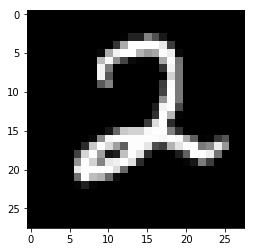

In [4]:
num_samples = mnist.train.num_examples
print('Training images shape X: ', mnist.train.images.shape)
print('Training labels shape y:',mnist.train.labels.shape)
print('Number of data examples:',num_samples)
plt.imshow(np.reshape(mnist.train.images[16], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
plt.show()

In [5]:
def weight(shape):
    initial = tf.truncated_normal(shape,stddev=0.001)
    return tf.Variable(initial)

In [6]:
def bias(shape):
    initial = tf.constant(0.,shape=shape)
    return tf.Variable(initial)

In [7]:
def build_mask(z_dim,h_dim,layer_dims):
    L = len(layer_dims)
    mask={}
    input_sel_z=np.arange(0,z_dim)
    input_sel_h = np.zeros(h_dim)-1 
    input_sel = np.concatenate((input_sel_z,input_sel_h))
    output_sel = np.concatenate((input_sel_z, input_sel_z))
    m_h=[input_sel]
    for l in range(1,L-1):
        m_h.append(np.random.randint(z_dim-1,size=layer_dims[l]))
    m_h.append(output_sel)
#     print('m_h: {}'.format(m_h))
    #hidden
    for l in range(1,L-1):
        M=np.array([[m_h[l][k]>=m_h[l-1][d] for d in range(layer_dims[l-1])] for k in range(layer_dims[l])],dtype=int)
        mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
    #output
    for l in [L-1]:
        M=np.array([[m_h[l][k]>m_h[l-1][d] for d in range(layer_dims[l-1])] for k in range(layer_dims[l])],dtype=int)
        mask['M'+str(l)]=tf.constant(M,dtype=tf.float32,name='M'+str(l))
    #direct
    input_sel_direct = input_sel_z
    output_sel_direct = np.concatenate((input_sel_z, input_sel_z))
    M=np.array([[i<j for i in input_sel_direct] for j in output_sel_direct],dtype=int)
    mask['MA']=tf.constant(M,dtype=tf.float32,name='MA')  
    
    return mask

In [8]:
def encoder(X,hidden_dim=500,z_dim=2,h_dim=128):
    x_dim = X.get_shape().as_list()[1]
    W1=weight([hidden_dim,x_dim])
    b1=bias([hidden_dim])
    W2=weight([hidden_dim,hidden_dim])
    b2=bias([hidden_dim])
    W3s=weight([z_dim,hidden_dim])
    W3m=weight([z_dim,hidden_dim])
    W3h=weight([h_dim,hidden_dim])
    b3s=bias([z_dim])-10
    b3m=bias([z_dim])
    b3h=bias([h_dim])
    
    A = tf.nn.relu(tf.add(tf.matmul(X,tf.transpose(W1)),b1))
    A = tf.nn.relu(tf.add(tf.matmul(A,tf.transpose(W2)),b2))
    A1 = 0.01*tf.nn.softplus(tf.add(tf.matmul(A,tf.transpose(W3s)),b3s))#sigma
    A2 = tf.add(tf.matmul(A,tf.transpose(W3m)),b3m)#mu
    A3 = tf.add(tf.matmul(A,tf.transpose(W3h)),b3h)#h    
    
    return A1,A2,A3

In [9]:
def decoder(Z,hidden_dim=500,out_dim=784):
    z_dim = Z.get_shape().as_list()[1]
    W1 = weight([hidden_dim,z_dim])
    b1 = bias([hidden_dim])
    W2=weight([hidden_dim,hidden_dim])
    b2=bias([hidden_dim])
    W3 = weight([out_dim,hidden_dim])
    b3 = weight([out_dim])
    A = tf.nn.relu(tf.add(tf.matmul(Z,tf.transpose(W1)),b1))
    A = tf.nn.relu(tf.add(tf.matmul(A,tf.transpose(W2)),b2))
    A = tf.nn.sigmoid(tf.add(tf.matmul(A,tf.transpose(W3)),b3))

    return A

In [10]:
def iaf(Z,h,hidden_dim):
    z_dim=Z.get_shape().as_list()[1]
    h_dim=h.get_shape().as_list()[1]
    layer_dims=[z_dim+h_dim,hidden_dim,hidden_dim,2*z_dim]
    mask=build_mask(z_dim,h_dim,layer_dims)    

    W1=weight([hidden_dim,z_dim+h_dim])
    b1=bias([hidden_dim])
    W2=weight([hidden_dim,hidden_dim])
    b2=bias([hidden_dim])+2.
    W3=weight([2*z_dim,hidden_dim])
    b3=bias([2*z_dim])+2.
    WA=weight([2*z_dim,z_dim])
    #first hidden
    inpu=tf.concat([Z,h],axis=1)
    A = tf.add(tf.matmul(inpu,tf.transpose(np.dot(W1,mask['M1']))),b1)
    A = tf.nn.relu(A) 
    #second hidden
    A = tf.add(tf.matmul(A,tf.transpose(np.dot(W2,mask['M2']))),b2)
    A = tf.nn.relu(A)
    #output
    A = tf.matmul(A,tf.transpose(np.dot(W3,mask['M3'])))
    #direct_output
    A_dr=tf.matmul(Z,tf.transpose(np.dot(WA,mask['MA'])))
    #total output
    A = tf.add((A+A_dr),b3)
    
    return A[:,:z_dim], A[:,z_dim:]   

In [11]:
save_path='newiaf/vae4.ckpt'

In [12]:
def neg_elbo():
    # log p(x|z_t)
    log_px_z = -tf.reduce_sum(X * tf.log(1e-10 + x_mu) + (1-X) * tf.log(1e-10 + 1 - x_mu), axis=-1)      
    log_pz=-0.5*tf.reduce_sum(tf.log(2*math.pi)+tf.square(Z),axis=-1)    
    det=tf.zeros_like(z_sigmas[0])
    for item in z_sigmas:
        det+=tf.log(item+1e-6)
    log_qz_x=-0.5*tf.reduce_sum(tf.log(2*math.pi)+tf.square(epsilon)+tf.log(z_sigma_0)+det,axis=-1)
    
    return tf.reduce_mean(log_px_z+(log_qz_x-log_pz))

In [13]:
tf.reset_default_graph()
X=tf.placeholder(tf.float32,[None,784])
z_sigma_0,z_mu,h = encoder(X,hidden_dim=500,z_dim=2,h_dim=200)
epsilon = tf.random_normal(tf.shape(z_mu),0,1,dtype=tf.float32)
Z = np.dot(z_sigma_0 , epsilon) + z_mu
z_sigmas=[]
for i in range(2):
    Z=Z[:,::-1]
    m,s=iaf(Z,h,400)
    z_sigma=tf.sigmoid(s)
    Z=np.dot(z_sigma,Z)+np.dot(1-z_sigma,m)
    z_sigmas.append(z_sigma)

x_mu = decoder(Z,hidden_dim=500,out_dim=784)

In [14]:
def train(batch_size=32,num_epochs=100,log_every=1,verbose=False,vis_on=True):
    loss=neg_elbo()
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    saver=tf.train.Saver()
    

    with tf.Session() as sess:      
        sess.run(tf.global_variables_initializer())
        sample,_=mnist.train.next_batch(batch_size)
        print(np.mean(sess.run(z_sigma_0,{X:sample})))
        if vis_on:
            vis = visdom.Visdom()
            mini_batch, mini_label = mnist.train.next_batch(batch_size)
            watchval=sess.run(Z,{X:mini_batch})
            
            colors = np.array([[255,255,0],[0,0,128],[0,100,0],[255,0,0],[255,255,0],[0,0,128],[0,100,0],[255,0,0],[255,255,0],[0,0,128]])
            print(np.argmax(mini_label,1)+1)
            old_win = vis.scatter(
                X=watchval,Y=(np.argmax(mini_label,1)+1),
                opts=dict(
                markersize=10,markercolor=colors,
                ),
            )
        for epoch in range(num_epochs):
            mini_batch, mini_label = mnist.train.next_batch(batch_size)
            _,temp_cost=sess.run([optimizer,loss],{X:mini_batch})
            
            if verbose and epoch%log_every==0:
                print('%d-th train'%epoch+' cost {} '.format(temp_cost))
                if math.isnan(temp_cost)==False:
                    saver.save(sess,save_path)
                
            if vis_on and epoch%10==0:  
                watchval=sess.run(Z,{X:mini_batch})
                vis.scatter(                
                    X=watchval,Y=(np.argmax(mini_label,1)+1),
                    opts=dict(
                        markersize=10,
                        markercolor=colors,
                    ),
                    update = 'new',
                    win = old_win,
                ) 

        saver.save(sess,save_path)              
    return None

In [16]:
train(num_epochs=500000,batch_size=128,log_every=10000,verbose=True,vis_on=False)

4.5417707e-07
0-th train cost 557.5578002929688 
10000-th train cost 141.82142639160156 
20000-th train cost 137.8793182373047 
30000-th train cost 132.97280883789062 
40000-th train cost 134.6988525390625 
50000-th train cost 128.27029418945312 
60000-th train cost 130.2383575439453 
70000-th train cost 133.338134765625 
80000-th train cost 136.84231567382812 
90000-th train cost 126.45526123046875 
100000-th train cost 133.8704833984375 
110000-th train cost 132.63650512695312 
120000-th train cost 126.42003631591797 
130000-th train cost 139.3988494873047 
140000-th train cost 135.9068603515625 
150000-th train cost 128.76803588867188 
160000-th train cost 132.7381134033203 
170000-th train cost 128.68112182617188 
180000-th train cost 127.39732360839844 
190000-th train cost 127.91256713867188 
200000-th train cost 127.59671020507812 
210000-th train cost 122.21945190429688 
220000-th train cost 124.93043518066406 
230000-th train cost 124.46627044677734 
240000-th train cost 127.7

KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from newiaf/vae4.ckpt


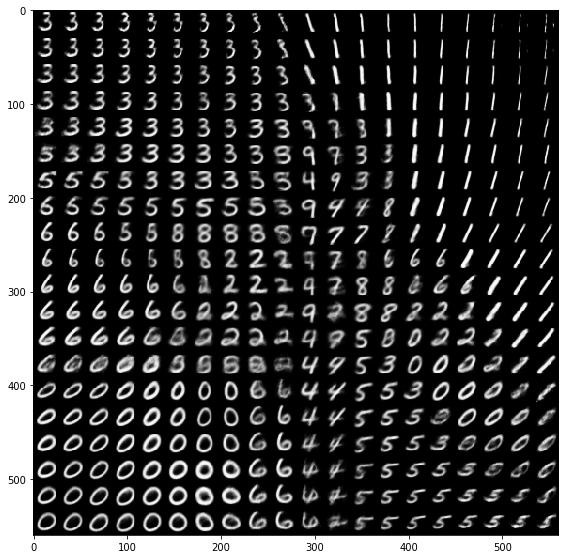

In [31]:
nx = ny = 20
batch_size = 20
x_values = np.linspace(-2,2 ,nx)
y_values = np.linspace(-2,2, ny)
canvas = np.empty((28*ny, 28*nx))
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    d = np.zeros([batch_size,2],dtype='float32')
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            tempz = np.array([[xi, yi]])
            d[0] = tempz
            x_mean = sess.run(x_mu, feed_dict={Z: d})
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

a=plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()